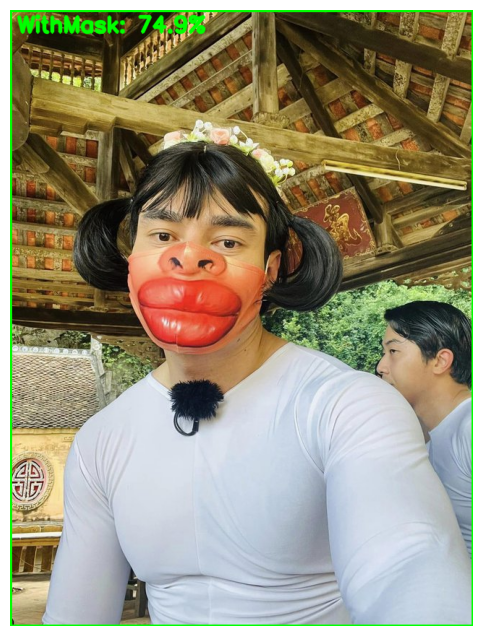

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import joblib
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import os

import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog

# --- Cấu hình ---
IMAGE_SIZE = (128, 128)
HOG_PARAMS = {
    'orientations':    9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm':      'L2-Hys'
}
MODEL_PATH = '/kaggle/input/hog_rf_facemask/scikitlearn/default/1/hog_8x2_rf_face_mask_model.joblib'
URL = 'https://cafefcdn.com/203337114487263232/2022/9/26/photo-4-16641964880911003992954.jpg'
# --- Hàm trích xuất HOG ---
def extract_hog_features(gray_img: np.ndarray) -> np.ndarray:
    img_resized = resize(gray_img, IMAGE_SIZE, anti_aliasing=True)
    return hog(img_resized, **HOG_PARAMS).reshape(1, -1)

# --- Load model ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Không tìm thấy file model tại: {MODEL_PATH}")
data = joblib.load(MODEL_PATH)
clf = data['model']
le  = data['label_encoder']

# --- Tải ảnh ---
def load_image_from_url(url):
    resp = requests.get(url, timeout=5)
    resp.raise_for_status()
    return Image.open(BytesIO(resp.content)).convert('RGB')

try:
    pil_img = load_image_from_url(URL)
except Exception as e:
    raise RuntimeError(f"Không tải được ảnh từ URL: {e}")

# --- Chuyển PIL → OpenCV BGR ---
img_rgb = np.array(pil_img)
frame   = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# --- Classification toàn khung ảnh ---
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
feat = extract_hog_features(gray)

pred_idx = clf.predict(feat)[0]
prob     = np.max(clf.predict_proba(feat))
label    = le.inverse_transform([int(pred_idx)])[0]

# --- Vẽ kết quả lên ảnh ---
color = (0,255,0) if label == 'WithMask' else (0,0,255)
h, w = frame.shape[:2]
cv2.rectangle(frame, (0,0), (w, h), color, 4)
cv2.putText(frame, f"{label}: {prob*100:.1f}%",
            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3, cv2.LINE_AA)

# --- Hiển thị với matplotlib (tránh cv2.imshow) ---
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
